In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.5)
plt.rc("font", family="serif")  # Use serif font for a professional look
plt.rc("text", usetex=False)    # Use LaTeX-style rendering if preferred

In [3]:
# Load data
state_results = pd.read_csv('results_state_scaling.csv')
model_results = pd.read_csv('results_model_scaling.csv')
tree_results = pd.read_csv('results_tree_depth.csv')
nn_results = pd.read_csv('results_nn_scaling.csv')

Have to do some special filtering for the nn runtime data bc it captures total runtime. If total runtime is greater than 1200, then we should actually say it timed out (status code 9).

In [4]:
# Process NN data to correct timeouts
nn_results.loc[nn_results["time"] > 1200, "status"] = "error"
nn_results.loc[nn_results["time"] > 1200, "message"] = "Optimization failed with status code 9"
nn_results.loc[nn_results["time"] > 1200, "objective"] = None
nn_results

,Unnamed: 0,n_layers,n_neurons,instance,method,status,time,objective,message
0,0,1,5,0,direct,error,1200.018242,NaN,Optimization failed with status code 9
1,1,1,5,0,decomp,optimal,1.575128,107.114677,NaN
2,2,1,5,1,direct,error,1200.007653,NaN,Optimization failed with status code 9
3,3,1,5,1,decomp,optimal,1.618883,284.949785,NaN
4,4,1,5,2,direct,error,1200.010068,NaN,Optimization failed with status code 9
...,...,...,...,...,...,...,...,...,...
155,155,2,20,7,decomp,error,1376.726282,NaN,Optimization failed with status code 9
156,156,2,20,8,direct,error,1200.716897,NaN,Optimization failed with status code 9
157,157,2,20,8,decomp,error,1559.433134,NaN,Optimization failed with status code 9
158,158,2,20,9,direct,error,1200.326906,NaN,Optimization failed with status code 9


In [5]:
def process_runtime_data(data, group_col, is_nn=False):
    """
    Generalized function to process runtime data.
    """
    # For NN data, create a combined grouping column (hidden layers, neurons)
    if is_nn:
        data['group'] = data.apply(
            lambda row: f"({row['n_layers']},{row['n_neurons']})",
            axis=1
        )
        group_col = 'group'

    # Adjust for suboptimal statuses
    data["adjusted_status"] = data["status"]
    for i, row in data.iterrows():
        if row["status"] == "suboptimal":
            matching_row = data[
                (data[group_col] == row[group_col]) &
                (data["instance"] == row["instance"]) &
                (data["method"] == "decomp")
            ]
            if not matching_row.empty and np.isclose(row["objective"], matching_row["objective"].values[0], rtol=1e-12):
                data.loc[i, "adjusted_status"] = "optimal"

    # Compute geometric mean and SD of runtimes for all successful runs
    line_data = data[data["adjusted_status"] == "optimal"].groupby([group_col, "method"]).agg(
        geom_mean=("time", lambda x: np.exp(np.mean(np.log(x)))),
        geom_std=("time", lambda x: np.exp(np.std(np.log(x))))
    ).reset_index()

    line_data["yerr_minus"] = line_data["geom_mean"] - line_data["geom_mean"]/line_data["geom_std"]
    line_data["yerr_plus"] = line_data["geom_mean"]*line_data["geom_std"] - line_data["geom_mean"]

    # Initialize t_test_results with default values
    t_test_results = pd.DataFrame({
        group_col: data[group_col].unique(),
        't_stat': np.nan,
        'p_value': np.nan,
        'significance': ''
    })

    # Filter for valid pairs only for t-tests
    valid_instances = data.groupby([group_col, "instance"]).filter(
        lambda group: group["method"].nunique() == 2 and all(group["adjusted_status"] == "optimal")
    )

    # Only perform t-tests where we have valid pairs
    for name, group in valid_instances.groupby(group_col):
        if len(group[group["method"] == "direct"]) > 0 and len(group[group["method"] == "decomp"]) > 0:
            t_stat, p_val = stats.ttest_rel(
                np.log(group[group["method"] == "direct"]["time"]),
                np.log(group[group["method"] == "decomp"]["time"])
            )
            idx = t_test_results[t_test_results[group_col] == name].index
            t_test_results.loc[idx, 't_stat'] = t_stat
            t_test_results.loc[idx, 'p_value'] = p_val
            # Add significance code
            if p_val < 0.001:
                t_test_results.loc[idx, 'significance'] = "§"
            elif p_val < 0.01:
                t_test_results.loc[idx, 'significance'] = "†"
            elif p_val < 0.05:
                t_test_results.loc[idx, 'significance'] = "*"

    line_data_with_sig = line_data.merge(t_test_results, on=group_col, how="left")
    return line_data_with_sig

In [6]:
states_plot_data = process_runtime_data(state_results, group_col="n_states")
models_plot_data = process_runtime_data(model_results, group_col="n_models")
trees_plot_data = process_runtime_data(tree_results, group_col="depth")
nn_plot_data = process_runtime_data(nn_results, group_col=None, is_nn=True)

In [7]:
trees_plot_data

,depth,method,geom_mean,geom_std,yerr_minus,yerr_plus,t_stat,p_value,significance
0,2,decomp,0.180655,2.422027,0.106066,0.256896,6.185831,4.514457e-04,§
1,2,direct,0.701720,1.245187,0.138174,0.172053,6.185831,4.514457e-04,§
2,3,decomp,0.165840,1.116291,0.017277,0.019286,16.304733,2.015311e-07,§
3,3,direct,1.919622,1.589844,0.712194,1.132278,16.304733,2.015311e-07,§
4,4,decomp,0.176108,1.339767,0.044661,0.059836,18.308497,8.149172e-08,§
5,4,direct,4.323434,1.548123,1.530739,2.369772,18.308497,8.149172e-08,§
6,6,decomp,0.655979,1.243261,0.128351,0.159574,23.787171,1.038778e-08,§
7,6,direct,82.104282,1.819731,36.985362,67.303396,23.787171,1.038778e-08,§
8,8,decomp,1.729680,1.647705,0.679929,1.120322,31.643914,1.082566e-09,§
9,8,direct,665.324672,1.418007,196.127484,278.110052,31.643914,1.082566e-09,§


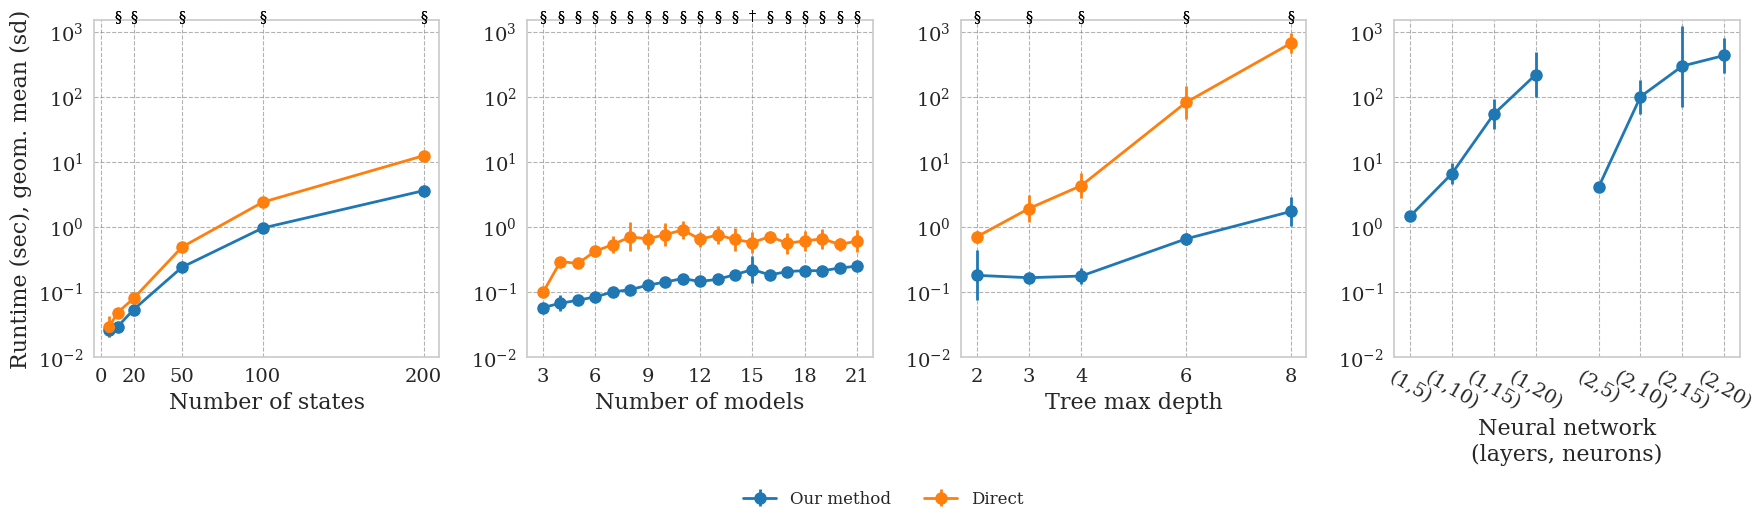

In [8]:
# Set up the figure and subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=False)

# Define the plot parameters
plots = [
    (states_plot_data, "n_states", "Number of states", [0, 20, 50, 100, 200], axes[0], [1e-2, 1.5e3]),
    (models_plot_data, "n_models", "Number of models", [3, 6, 9, 12, 15, 18, 21], axes[1], [1e-2, 1.5e3]),
    (trees_plot_data, "depth", "Tree max depth", [2, 3, 4, 6, 8], axes[2], [1e-2, 1.5e3]),
    (nn_plot_data, "group", "Neural network\n(layers, neurons)",
     [f"({layers},{neurons})" for layers in [1, 2] for neurons in [5, 10, 15,20]],
        axes[3], [1e-2, 1.5e3])
]

# Colors for the methods
colors = {"decomp": "#1f77b4", "direct": "#ff7f0e"}
labels = {"decomp": "Our method", "direct": "Direct"}

# Loop through plots
for data, x_col, x_label, x_ticks, ax, y_limit in plots:
    # neural network has to be handled differently because of (hidden layers, neurons)
    if x_label.startswith("Neural network"):
        # Create x positions with gap between layer groups
        x_positions = []
        for config in x_ticks:
            layers = int(config.split(',')[0].strip('()'))
            pos = x_ticks.index(config)
            if layers == 2:
                pos += 0.5  # Add gap between layer groups
            x_positions.append(pos)

        # Plot separately for each layer and method
        for method in data["method"].unique():
            subset = data[data["method"] == method]
            for layer in [1, 2]:
                layer_data = subset[subset["group"].str.startswith(f"({layer},")]
                layer_data = layer_data.set_index("group").reindex(
                    [g for g in x_ticks if g.startswith(f"({layer},")]
                ).reset_index()
                ax.errorbar(
                    [x_positions[x_ticks.index(g)] for g in layer_data["group"]],
                    layer_data["geom_mean"],
                    yerr=[layer_data["yerr_minus"], layer_data["yerr_plus"]],
                    fmt='-o',
                    label=labels[method] if layer == 1 else "",
                    color=colors[method],
                    linewidth=2,
                    markersize=8
                )

        # Add significance annotations
        for _, row in data.iterrows():
            ax.text(x_positions[x_ticks.index(row[x_col])], y_limit[1], row["significance"],
                    ha='center', fontsize=10, color='black')

        # Set x-axis ticks
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_ticks, rotation=-30, ha='center')
    # all other plots only have a single measure of complexity
    else:
        for method in data["method"].unique():
            subset = data[data["method"] == method]
            ax.errorbar(
                subset[x_col],
                subset["geom_mean"],
                yerr=[subset["yerr_minus"], subset["yerr_plus"]],
                fmt='-o',
                label=labels[method],
                color=colors[method],
                linewidth=2,
                markersize=8
            )
            ax.scatter(subset[x_col], subset["geom_mean"], color=colors[method], s=50, zorder=3)

        # Add statistical significance annotations
        for _, row in data.iterrows():
            ax.text(row[x_col], y_limit[1], row["significance"],
                    ha='center', fontsize=10, color='black')

        # Set x-axis ticks
        ax.set_xticks(x_ticks)

    # Set log scale for y axis
    ax.set_yscale('log')

    # Set y-axis limits and labels
    ax.set_ylim(y_limit)
    ax.set_xlabel(x_label, fontsize=16)
    # Adjust tick parameters for smaller ticks and labels
    ax.tick_params(
        axis="both",           # Apply to both x and y axes
        direction="out",       # Ticks face outward
        length=4,              # Shorter ticks
        width=0.8,             # Thinner ticks
        labelsize=14           # Smaller tick labels
    )

    # Add grid lines
    ax.grid(visible=True, which="major", linestyle="--", linewidth=0.8, color="gray", alpha=0.6)
    ax.grid(visible=False, which="minor")  # No minor grid lines

# Shared Y-axis label
axes[0].set_ylabel("Runtime (sec), geom. mean (sd)", fontsize=16)

# Shared legend
handles, legend_labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, legend_labels,
    loc="lower center",          # Position legend below the plots
    ncol=2,                      # Number of columns in the legend
    fontsize=12,                 # Font size of legend text
    frameon=False,               # No frame around the legend
    bbox_to_anchor=(0.5, 0.1)   # Move the legend closer (adjust y-coordinate here)
)

# Adjust layout for ICML paper style
plt.tight_layout(rect=[0, 0.15, 1, 1])

# Save the plot with high DPI for publication
plt.savefig("results_plot.png", dpi=600, bbox_inches="tight")
plt.show()

In [9]:
def process_props_results(data, group_col="n_states", is_nn=False):
    # Map statuses to desired categories
    def map_status(status, message):
        if status == "optimal":
            return "Optimal"
        elif status == "suboptimal":
            return "Suboptimal"
        elif status == "error" and message == "Optimization failed with status code 9":
            return "Timeout"
        else:
            return "Other"

    # for nn data have to make a combined group column
    if is_nn:
        data['group'] = data.apply(
            lambda row: f"({row['n_layers']},{row['n_neurons']})",
            axis=1
        )
        group_col = 'group'

    # Map statuses to a new column
    data["mapped_status"] = data.apply(lambda row: map_status(row["status"], row["message"]), axis=1)

    # Group by experiment and method, then count mapped status occurrences
    grouped = data.groupby([group_col, "method", "mapped_status"]).size().reset_index(name="count")

    # Pivot table to get mapped status counts as columns
    pivot = grouped.pivot_table(index=[group_col, "method"], columns="mapped_status", values="count", fill_value=0)

    # Ensure all required columns are present in the correct order
    required_columns = ["Optimal", "Suboptimal", "Timeout", "Other"]
    for col in required_columns:
        if col not in pivot.columns:
            pivot[col] = 0  # Add missing columns with zero values

    # Reorder columns to match the desired order
    pivot = pivot[required_columns]

    # Add chi-square results with significance codes
    chi_square_results = []
    for config in pivot.index.get_level_values(group_col).unique():
        subset = pivot.loc[config]
        subset = subset.loc[:, (subset != 0).any(axis=0)]  # Remove all-zero columns
        if len(subset) > 1 and subset.shape[1] > 1:  # Ensure multiple methods and statuses
            chi2, p, _, _ = chi2_contingency(subset.values)
            # Add significance code
            sig_code = ""
            if p < 0.001:
                sig_code = "§"
            elif p < 0.01:
                sig_code = "†"
            elif p < 0.05:
                sig_code = "*"

            chi_square_results.append({
                "config": config,
                "chi2": chi2,
                "p_value": p,
                "significance": sig_code
            })
        else:
            chi_square_results.append({
                "config": config,
                "chi2": None,
                "p_value": None,
                "significance": ""
            })

    # Create a DataFrame for chi-square results
    chi_square_df = pd.DataFrame(chi_square_results).set_index("config")

    # Normalize proportions to percentages and reset index
    pivot = pivot.div(pivot.sum(axis=1), axis=0).multiply(100).round(0).reset_index()
    pivot.columns.name = None  # Remove column index name

    # Rename columns for clarity
    pivot = pivot.rename(columns={
        "Optimal": "Optimal (%)",
        "Suboptimal": "Suboptimal (%)",
        "Timeout": "Timeout (%)",
        "Other": "Other (%)"
    })

    # Merge chi-square results
    pivot = pivot.merge(chi_square_df, left_on=group_col, right_index=True, how="left")

    return pivot


In [10]:
# Process each dataset
state_table = process_props_results(state_results, group_col="n_states")
model_table = process_props_results(model_results, group_col="n_models")
tree_table = process_props_results(tree_results, group_col="depth")
nn_table = process_props_results(nn_results, group_col=None, is_nn=True)

# Display the tables
print("State Scaling Table:")
print(state_table)
print("\nModel Scaling Table:")
print(model_table)
print("\nTree Depth Table:")
print(tree_table)
print("\nNeural Network Table:")
print(nn_table)



State Scaling Table:
    n_states  method  Optimal (%)  Suboptimal (%)  Timeout (%)  Other (%)  \
0          5  decomp        100.0             0.0          0.0        0.0   
1          5  direct         60.0            40.0          0.0        0.0   
2         10  decomp        100.0             0.0          0.0        0.0   
3         10  direct         70.0            30.0          0.0        0.0   
4         20  decomp        100.0             0.0          0.0        0.0   
5         20  direct         70.0            30.0          0.0        0.0   
6         50  decomp        100.0             0.0          0.0        0.0   
7         50  direct        100.0             0.0          0.0        0.0   
8        100  decomp        100.0             0.0          0.0        0.0   
9        100  direct        100.0             0.0          0.0        0.0   
10       200  decomp        100.0             0.0          0.0        0.0   
11       200  direct         80.0            20.0      

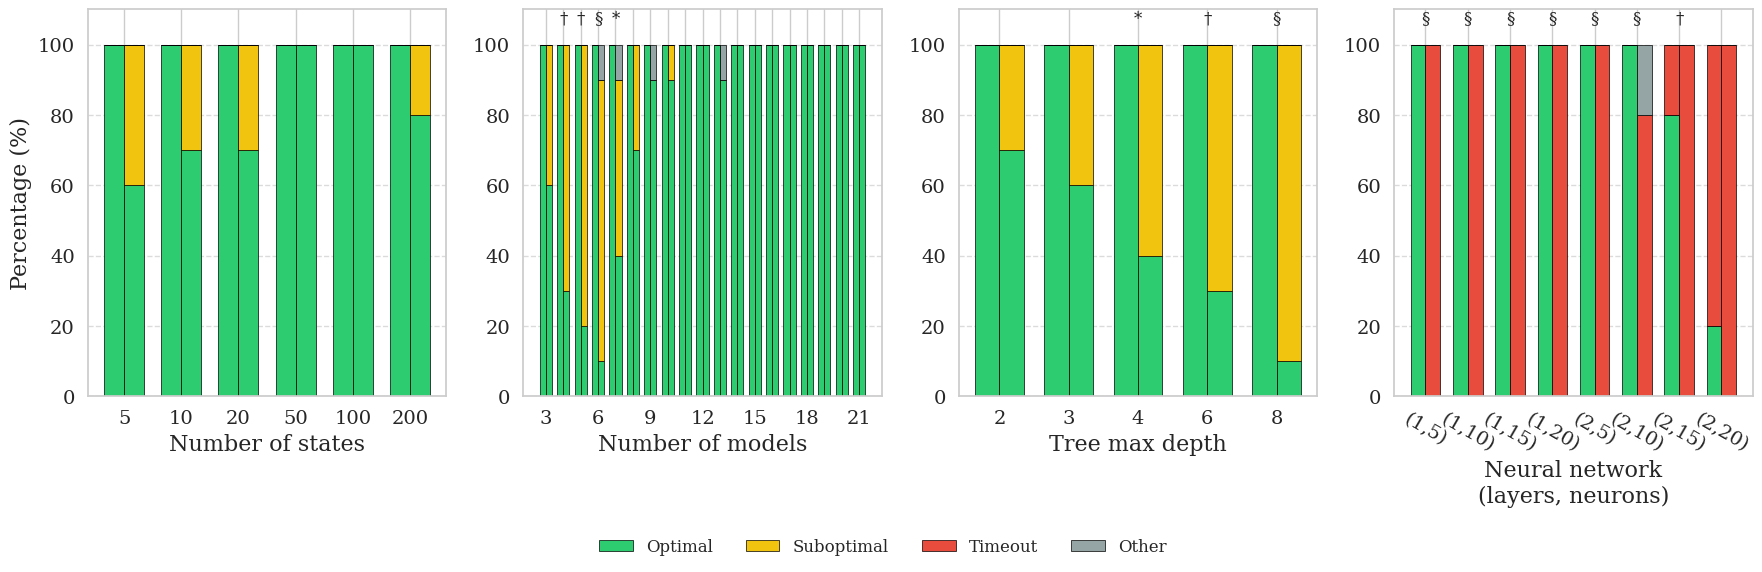

In [11]:
# Set up the figure
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

# Define the plot parameters
plots = [
    (state_table, "n_states", "Number of states", [5, 10, 20, 50, 100, 200]),
    (model_table, "n_models", "Number of models", list(range(3, 22))),
    (tree_table, "depth", "Tree max depth", [2, 3, 4, 6, 8]),
    (nn_table, "group", "Neural network\n(layers, neurons)",
     [f"({layers},{neurons})" for layers in [1, 2] for neurons in [5, 10, 15,20]])
]

# Colors for the status categories
status_colors = {
    "Optimal (%)": "#2ecc71",     # Green
    "Suboptimal (%)": "#f1c40f",  # Yellow
    "Timeout (%)": "#e74c3c",     # Red
    "Other (%)": "#95a5a6"        # Gray
}

# Loop through plots
for i, (data, x_col, x_label, x_ticks) in enumerate(plots):
    ax = axes[i]

    # Calculate bar positions
    x = np.arange(len(x_ticks))
    width = 0.35

    # Track total heights for significance markers
    total_heights = np.zeros(len(x_ticks))

    # Plot bars for each method
    for j, method in enumerate(["decomp", "direct"]):
        method_data = data[data["method"] == method]
        bottom = np.zeros(len(x_ticks))

        for status in ["Optimal (%)", "Suboptimal (%)", "Timeout (%)", "Other (%)"]:
            # Match data with x_ticks
            heights = []
            for tick in x_ticks:
                val = method_data[method_data[x_col] == tick][status].values
                heights.append(val[0] if len(val) > 0 else 0)

            ax.bar(x + (j-0.5)*width, heights, width,
                  bottom=bottom,
                  color=status_colors[status],
                  label=status if (i == 0 and j == 0) else "",
                  edgecolor='black',
                  linewidth=0.5)
            bottom += heights

            # Update total heights
            if j == 1:  # After plotting Direct (second) bar
                total_heights = np.maximum(total_heights, bottom)

    # Add significance symbols
    for idx, tick in enumerate(x_ticks):
        sig_code = data[data[x_col] == tick]["significance"].iloc[0]
        if sig_code:  # Only add symbol if significant
            ax.text(x[idx], total_heights[idx] + 5, sig_code,
                ha='center', va='bottom', fontsize=12)

    # Customize the plot
    ax.set_xticks(x)

    # special handling for model scaling plot
    if x_label.startswith("Number of models"):
        ax.set_xticklabels([str(tick) if tick % 3 == 0 else "" for tick in x_ticks], fontsize=14)
    # special handling for nn scaling plot
    elif x_label.startswith("Neural network"):
        ax.set_xticklabels(x_ticks, fontsize=14, rotation=-30, ha='center')
    else:
        ax.set_xticklabels(x_ticks, fontsize=14)

    ax.set_xlabel(x_label, fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Set y-axis limit to accommodate stars
    ax.set_ylim(0, max(total_heights) + 10)

# Set the shared y-label for the first plot only
axes[0].set_ylabel("Percentage (%)", fontsize=16)

# Create legend for status only
handles = [plt.Rectangle((0,0), 1, 1,
                        facecolor=color,
                        edgecolor='black',
                        linewidth=0.5)
          for color in status_colors.values()]
labels = [status.replace(" (%)", "") for status in status_colors.keys()]

# Add the legend
fig.legend(handles, labels,
          loc='lower center',
          ncol=4,
          fontsize=12,
          frameon=False,
          bbox_to_anchor=(0.5, 0.02))

# Adjust layout
plt.tight_layout(rect=[0, 0.08, 1, 1])

# Save the plot
plt.savefig("results_props_plot.png", dpi=600, bbox_inches="tight")
plt.show()

## Ablation study analysis

In [13]:
ablation_results = pd.read_csv('results_ablation.csv')

In [14]:
ablation_results

,Unnamed: 0,ablation_step,instance,status,time,objective,message
0,0,ml_bounds,0,suboptimal,669.115127,87.722496,NaN
1,1,affine_bounds,0,suboptimal,507.833950,87.721729,NaN
2,2,initial_v_bounds,0,suboptimal,317.388934,87.721729,NaN
3,3,tightened_v_bounds,0,optimal,2.579932,87.721729,NaN
4,4,baseline,0,optimal,2.206425,87.721729,NaN
5,5,ml_bounds,1,suboptimal,584.291845,163.700072,NaN
6,6,affine_bounds,1,suboptimal,619.061046,163.700072,NaN
7,7,initial_v_bounds,1,suboptimal,478.338360,163.700072,NaN
8,8,tightened_v_bounds,1,optimal,1.213185,163.700072,NaN
9,9,baseline,1,optimal,1.428917,163.700072,NaN


In [15]:
def process_ablation_data(data):
    """
    Process ablation study runtime data.

    Args:
        data (pd.DataFrame): The ablation results dataset.

    Returns:
        pd.DataFrame: Summary statistics of runtimes by ablation step.
    """
    # Create copy to avoid modifying original
    data = data.copy()

    # Get total number of unique instances
    total_instances = data["instance"].nunique()

    # Adjust for suboptimal statuses
    data["adjusted_status"] = data["status"]

    # For each instance, compare objectives with baseline
    for instance in data["instance"].unique():
        baseline = data[
            (data["instance"] == instance) &
            (data["ablation_step"] == "baseline")
        ]

        if not baseline.empty and baseline["status"].iloc[0] == "optimal":
            baseline_obj = baseline["objective"].iloc[0]

            # Find matching rows for this instance
            instance_rows = data[data["instance"] == instance]

            for idx in instance_rows.index:
                if (data.loc[idx, "status"] == "suboptimal" and
                    np.isclose(data.loc[idx, "objective"], baseline_obj, rtol=1e-12)):
                    data.loc[idx, "adjusted_status"] = "optimal"

    # Filter for valid results (optimal or adjusted optimal)
    valid_results = data[data["adjusted_status"] == "optimal"]

    # Compute summary statistics
    summary = valid_results.groupby("ablation_step").agg(
        geom_mean=("time", lambda x: np.exp(np.mean(np.log(x)))),
        geom_std=("time", lambda x: np.exp(np.std(np.log(x)))),
        n_solved=("time", "count")
    ).round(2)

    # Format the results as strings
    summary["runtime"] = summary.apply(
        lambda row: f"{row['geom_mean']:.2f} ({row['geom_std']:.2f})", axis=1
    )
    summary["solved"] = summary.apply(
        lambda row: f"{row['n_solved']}/{total_instances}", axis=1
    )

    # Select and rename columns
    result = summary[["runtime", "solved"]].rename(columns={
        "runtime": "Runtime (sec), mean (std dev)",
        "solved": "Instances solved"
    })

    # Sort steps in logical order
    step_order = ["ml_bounds", "affine_bounds", "initial_v_bounds",
                  "tightened_v_bounds", "baseline"]
    result = result.reindex(step_order)

    return result

In [16]:
# Process and display results
ablation_summary = process_ablation_data(ablation_results)
print(ablation_summary)

                   Runtime (sec), mean (std dev) Instances solved
ablation_step                                                    
ml_bounds                          710.79 (1.22)             6/10
affine_bounds                      292.36 (1.64)             8/10
initial_v_bounds                   282.42 (1.59)             7/10
tightened_v_bounds                   1.85 (1.55)            10/10
baseline                             1.89 (1.56)            10/10
